# Significance testing

In [1]:
import numpy as np
import pandas as pd
import os
from checkFissFus2 import get_fiss_fus_all , fiss_fus_reassigned_label
from significance_test import sliding_window_cumsum,regularization,apply_function_to_arrays,convert_to_sig_test, apply_function_folder
import matplotlib.pyplot as plt
import pingouin as pg

## import and prepare data

### import data

In [2]:
dir_path_tox_adjusted = "../nellie_output/toxicity/adjusted"
dir_path_mdivi_adjusted = "../nellie_output/mdivi/adjusted"

dir_path_mdivi_self = "../self_event/mdivi/num_area"
dir_path_tox_self = "../self_event/toxicity/num_area"

#dir_tox_meter = "D:/Internship/NTU/my_script/mitometer_output/toxin"
#dir_mdivi_meter = "D:/Internship/NTU/my_script/mitometer_output/mdivi"

dir_path_tox = "../nellie_output/toxicity/0.25"
dir_path_mdivi = "../nellie_output/mdivi/0.25"

dir_raw_tox = "D:/Internship/NTU/nellie_output/nellie_output/toxins/"
dir_raw_mdivi = "D:/Internship/NTU/nellie_output/nellie_output/mdivi/"

In [3]:

#mitometer
#fission_tox_meter, fusion_tox_meter, fiss_frame_meter, fus_frame_meter = get_fiss_fus_all(dir_tox_meter)
#fission_mdivi_meter, fusion_mdivi_meter, fiss_frame_meter_tox, fus_frame_meter_tox = get_fiss_fus_all(dir_mdivi_meter, isBound_to_min= False)

#after area threshold adjustment
fission_tox_adjusted, fusion_tox_adjusted, fiss_frame_meter, fus_frame_meter = get_fiss_fus_all(dir_path_tox_adjusted)
fission_mdivi_adjusted, fusion_mdivi_adjusted, fiss_frame_meter_tox, fus_frame_meter_tox = get_fiss_fus_all(dir_path_mdivi_adjusted, isBound_to_min= False)

#before area threshod adjustment
fission_tox, fusion_tox, fiss_frame_meter, fus_frame_meter = get_fiss_fus_all(dir_path_tox)
fission_mdivi, fusion_mdivi, fiss_frame_meter_tox, fus_frame_meter_tox = get_fiss_fus_all(dir_path_mdivi, isBound_to_min= False)

#self event
fission_mdivi_self, fusion_mdivi_self, fiss_self_frame_mdivi, fus_self_frame_mdivi = get_fiss_fus_all(dir_path_mdivi_self, isBound_to_min= False)
fission_tox_self, fusion_tox_self, fiss_self_frame, fus_self_frame = get_fiss_fus_all(dir_path_tox_self)

#fission fusion from Nellie author 
out_tox = apply_function_folder(dir_raw_tox, keywords="features_components", func=fiss_fus_reassigned_label)
out_mdivi = apply_function_folder(dir_raw_mdivi, keywords="features_components", func=fiss_fus_reassigned_label)

### fission/fusion from Nellie's Author

In [4]:
out_tox_copy = out_tox.copy()
x = out_tox.keys()
for key in x:
    condition = key.split("_")[2].split(".")[0]
    out_tox_copy[condition] = out_tox_copy.pop((key))

In [5]:
out_mdivi_copy = out_mdivi.copy()
x = out_mdivi.keys()
for key in x:
    condition = key.split("_")[1] +"_" +  key.split("_")[2].split(".")[0]
    out_mdivi_copy[condition] = out_mdivi_copy.pop((key))

In [6]:
fission_tox_nellie = [out_tox_copy["control"][2],out_tox_copy["FCCP"][2],out_tox_copy["oligomycin"][2],out_tox_copy["Rotenone"][2]]
fusion_tox_nellie = [out_tox_copy["control"][3],out_tox_copy["FCCP"][3],out_tox_copy["oligomycin"][3],out_tox_copy["Rotenone"][3]]
minimum = np.min([len(x) for x in fission_tox_nellie])
fission_tox_nellie = np.array([x[0:minimum] for x in fission_tox_nellie]).flatten()
fusion_tox_nellie = np.array([x[0:minimum] for x in fusion_tox_nellie]).flatten()

In [7]:
fission_mdivi_nellie = [out_mdivi_copy["control_3"][2],out_mdivi_copy["mdivi_3"][2]]
fusion_mdivi_nellie = [out_mdivi_copy["control_3"][3],out_mdivi_copy["mdivi_3"][3]]

fission_mdivi_nellie_10min = [out_mdivi_copy["control_10min"][2],out_mdivi_copy["mdivi_10min"][2]]
fusion_mdivi_nellie_10min = [out_mdivi_copy["control_10min"][3],out_mdivi_copy["mdivi_10min"][3]]

minimum_normal = np.min([len(x) for x in fission_mdivi_nellie])
minimum_10min = np.min([len(x) for x in fission_mdivi_nellie_10min])

fission_mdivi_nellie = np.array([x[0:minimum_normal] for x in fission_mdivi_nellie]).flatten()
fusion_mdivi_nellie = np.array([x[0:minimum_normal] for x in fusion_mdivi_nellie]).flatten()
fission_mdivi_nellie_10min = np.array([x[0:minimum_10min] for x in fission_mdivi_nellie_10min]).flatten()
fusion_mdivi_nellie_10min = np.array([x[0:minimum_10min] for x in fusion_mdivi_nellie_10min]).flatten()


### fission fusion algo output

In [8]:
#len(fusion_mdivi_meter[0]), len(fusion_mdivi_meter[1]), len(fusion_mdivi_meter[2]),  len(fusion_mdivi_meter[3])
#fusion_mdivi_meter[2] = fusion_mdivi_meter[2][0:61]
#fission_mdivi_meter[2] = fission_mdivi_meter[2][0:61]

In [9]:
#fusion_mdivi_meter

### take a minimum df value

In [10]:

# control 10min, control 3, mdivi 10min, mdivi 3
#extract result from mdivi (fission, self_fission, fusion, self_fusion) in 10 second and 1 second interval

# 10 min fission
fission_mdivi_10min = np.array([fission_mdivi[0],fission_mdivi[2] ])
fusion_mdivi_10min = np.array([fusion_mdivi[0],fusion_mdivi[2] ])
fission_mdivi_self_10min = np.array([fission_mdivi_self[0],fission_mdivi_self[2] ])
fusion_mdivi_self_10min = np.array([fusion_mdivi_self[0],fusion_mdivi_self[2] ])
#fission_mdivi_10min_meter = np.array([fission_mdivi_meter[0],fission_mdivi_meter[2] ])
#fusion_mdivi_10min_meter = np.array([fusion_mdivi_meter[0],fusion_mdivi_meter[2] ])

fission_mdivi_10min_adjusted = np.array([fission_mdivi_adjusted[0],fission_mdivi_adjusted[2] ])
fusion_mdivi_10min_adjusted = np.array([fusion_mdivi_adjusted[0],fusion_mdivi_adjusted[2] ])

# 1.3 second fission
fission_mdivi = np.array([x[0:minimum_normal] for x in [fission_mdivi[1],fission_mdivi[3] ]])
fusion_mdivi = np.array([x[0:minimum_normal] for x in[fusion_mdivi[1],fusion_mdivi[3] ]])
fission_mdivi_self = np.array([x[0:minimum_normal] for x in[fission_mdivi_self[1],fission_mdivi_self[3] ]])
fusion_mdivi_self = np.array([x[0:minimum_normal] for x in[fusion_mdivi_self[1],fusion_mdivi_self[3] ]])
#fission_mdivi_meter = np.array([x[0:minimum_normal] for x in[fission_mdivi_meter[1],fission_mdivi_meter[3] ]])
#fusion_mdivi_meter = np.array([x[0:minimum_normal] for x in[fusion_mdivi_meter[1],fusion_mdivi_meter[3] ]])

fission_mdivi_adjusted = np.array([x[0:minimum_normal] for x in[fission_mdivi_adjusted[1],fission_mdivi_adjusted[3] ]])
fusion_mdivi_adjusted =np.array([x[0:minimum_normal] for x in [fusion_mdivi_adjusted[1],fusion_mdivi_adjusted[3] ]])



#all event
fission_mdivi_all = fission_mdivi + fission_mdivi_self
fusion_mdivi_all = fusion_mdivi + fusion_mdivi_self

fission_mdivi_10min_all = fission_mdivi_10min + fission_mdivi_self_10min
fusion_mdivi_10min_all = fusion_mdivi_10min + fusion_mdivi_self_10min

minimum_tox = min(len(fission_tox[0]), len(fission_tox[1]), len(fission_tox[2]), len(fission_tox[3]))

### Area and label number

In [11]:
def get_label_info(path,name,max_size):
    df = pd.read_csv(path)
    mini_df = df[['t', 'label', 'area_raw' , 'solidity_raw', 'aspect_ratio_mean', 'divergence_mean' , 'convergence_mean', 'reassigned_label_raw'] ]

    frames = np.unique(mini_df['t'])
    label_num_all = []
    area_all = []
    raw_label_all = []
    frame_all = []
    for frame in frames:
        mini_df_frame = mini_df[mini_df['t'] == frame]
        label_num = len(np.unique(mini_df_frame['reassigned_label_raw']))
        area = np.sum(mini_df_frame['area_raw']) # can also do average area
        raw_label = len(np.unique(mini_df_frame['label']))
        
        if len(label_num_all) < max_size:
            label_num_all.append(label_num)
            area_all.append(area)
            raw_label_all.append(raw_label) 
            frame_all.append(frame)

    return np.array(label_num_all), np.array(area_all), np.array(raw_label_all), np.array(frame_all)

In [12]:
# check number of label over time/frame 
# check area over time/frame
#stream_frame = ['1','1','1','1','5','5','10','10']
#stream_con = ['0','0.5','1','2','1','0.5','0','2']
stream_file = ['control','FCCP','oligomycin','Rotenone']

main_dir = "D:/Internship/NTU/nellie_output/nellie_output/toxins/"
label_num_all = []
area_all = []
raw_label_all = []
frame_all = []


for s in range(len(stream_file)):
    # 1st part check area and number of label
    #im_concen = stream_con[s]
    im_concen = stream_file[s]

    #file_path_feature = main_dir + "ins1_" + im_concen + ".ome-ch0-features_components.csv"
    #file_path_feature = main_dir + "/" + im_frame + "_resized_" + im_concen + "_glu_1min_#1.ome-ch0-features_components.csv"
    file_path_feature = main_dir + "time_ins_" + im_concen + ".ome-ch0-features_components.csv"
    label_num, area, raw_label, frame = get_label_info(file_path_feature, im_concen, max_size = 137)
    if len(label_num_all) == 0:
        label_num_all = [label_num]
        area_all = [area]
        raw_label_all = [raw_label]
        frame_all = [frame]

    else:
        label_num_all.append(label_num)
        area_all.append(area)
        raw_label_all.append(raw_label)
        frame_all.append(frame)

## fission fusion ratio before and after the area threshold adjustment for toxicity data

In [13]:
# 
print(np.sum(fission_tox_adjusted[0]),np.sum(fission_tox_adjusted[1]), np.sum(fission_tox_adjusted[2]), np.sum(fission_tox_adjusted[3]))
print(np.sum(fusion_tox_adjusted[0]),np.sum(fusion_tox_adjusted[1]), np.sum(fusion_tox_adjusted[2]), np.sum(fusion_tox_adjusted[3]))

print(np.sum(fission_tox_adjusted[0]) / np.sum(fusion_tox_adjusted[0]) ,np.sum(fission_tox_adjusted[1]) / np.sum(fusion_tox_adjusted[1]), 
      np.sum(fission_tox_adjusted[2]) / np.sum(fusion_tox_adjusted[3]), np.sum(fission_tox_adjusted[3]) / np.sum(fusion_tox_adjusted[3]))

759 1245 619 503
616 914 479 441
1.2321428571428572 1.3621444201312911 1.4036281179138321 1.1405895691609977


In [14]:
print(np.sum(fission_tox[0]),np.sum(fission_tox[1]), np.sum(fission_tox[2]), np.sum(fission_tox[3]))
print(np.sum(fusion_tox[0]),np.sum(fusion_tox[1]), np.sum(fusion_tox[2]), np.sum(fusion_tox[3]))

print(np.sum(fission_tox[0]) / np.sum(fusion_tox[0]) ,np.sum(fission_tox[1]) / np.sum(fusion_tox[1]), 
      np.sum(fission_tox[2]) / np.sum(fusion_tox[3]), np.sum(fission_tox[3]) / np.sum(fusion_tox[3]))


880 1300 712 549
883 1327 714 603
0.9966024915062288 0.9796533534287868 1.1807628524046434 0.9104477611940298


## fission fusion ratio before and after area threshold adjustment for MDIVI

In [15]:
#order: control , mdivi , control 10min, mdivi 10 min
print("fission", np.sum(fission_mdivi_adjusted[0]),np.sum(fission_mdivi_adjusted[1]), np.sum(fission_mdivi_10min_adjusted[0]), np.sum(fission_mdivi_10min_adjusted[1]))
print("fusion",np.sum(fusion_mdivi_adjusted[0]),np.sum(fusion_mdivi_adjusted[1]), np.sum(fission_mdivi_10min_adjusted[0]), np.sum(fission_mdivi_10min_adjusted[1]))

print("control , mdivi, control 10min, mdivi 10min")
print(np.sum(fission_mdivi_adjusted[0]) / np.sum(fusion_mdivi_adjusted[0]) ,np.sum(fission_mdivi_adjusted[1]) / np.sum(fusion_mdivi_adjusted[1]), 
      np.sum(fission_mdivi_10min_adjusted[0]) / np.sum(fusion_mdivi_10min_adjusted[0]), np.sum(fission_mdivi_10min_adjusted[1]) / np.sum(fission_mdivi_10min_adjusted[1]))

fission 394 367 216 217
fusion 322 286 216 217
control , mdivi, control 10min, mdivi 10min
1.2236024844720497 1.2832167832167831 2.076923076923077 1.0


In [16]:
#order: control , mdivi , control 10min, mdivi 10 min
print("fission",np.sum(fission_mdivi[0]),np.sum(fission_mdivi[1]), np.sum(fission_mdivi_10min[0]), np.sum(fission_mdivi_10min[1]))
print("fusion",np.sum(fusion_mdivi[0]),np.sum(fusion_mdivi[1]), np.sum(fusion_mdivi_10min[0]), np.sum(fusion_mdivi_10min[1]))

print("control , mdivi, control 10min, mdivi 10min")
print(np.sum(fission_mdivi[0]) / np.sum(fusion_mdivi[0]) ,np.sum(fission_mdivi[1]) / np.sum(fusion_mdivi[1]), 
      np.sum(fission_mdivi_10min[0]) / np.sum(fusion_mdivi_10min[0]), np.sum(fission_mdivi_10min[1]) / np.sum(fusion_mdivi_10min[1]))

fission 452 421 300 262
fusion 463 410 286 298
control , mdivi, control 10min, mdivi 10min
0.9762419006479481 1.026829268292683 1.048951048951049 0.8791946308724832


## Regularization and data preparation

In [17]:
#column name
toxins = np.repeat(['control', 'FCCP', 'oligomycin', 'rotenone'], minimum_tox)
toxins_mdivi = np.repeat(['control', 'mdivi'], minimum_normal)
toxins_mdivi_10min = np.repeat(['control_10min', 'mdivi_10min'], minimum_10min)
assess_method_tox = np.repeat(['algorithm' , 'mitometer'], minimum_tox*4)
assess_mdivi = np.repeat(['algorithm' , 'mitometer'], minimum_normal*4)
assess_mdivi_10min= np.repeat(['algorithm' , 'mitometer'], minimum_10min*4)

### toxins

In [18]:
# data preparation with regularization (0 -> epsilon)
# window == 62 137

apply_regularization = False
epsilon = 0.01

fusion_tox,fusion_tox_pd = convert_to_sig_test(fusion_tox , toxins, regularization_=False, epsilon_=epsilon)
fission_tox, fission_tox_pd = convert_to_sig_test(fission_tox, toxins, regularization_=False, epsilon_=epsilon)

fusion_tox_adjusted,fusion_tox_adjusted_pd = convert_to_sig_test(fusion_tox_adjusted , toxins, regularization_=False, epsilon_=epsilon)
fission_tox_adjusted, fission_tox_adjusted_pd = convert_to_sig_test(fission_tox_adjusted, toxins, regularization_=False, epsilon_=epsilon)

fission_tox_self , fission_tox_self_pd= convert_to_sig_test(fission_tox_self,toxins, regularization_=False, epsilon_=epsilon)
fusion_tox_self, fusion_tox_self_pd = convert_to_sig_test(fusion_tox_self, toxins,regularization_=False, epsilon_=epsilon)

#fusion_tox_meter , fusion_tox_meter_pd = convert_to_sig_test(fusion_tox_meter, toxins,regularization_=False, epsilon_=epsilon)
#fission_tox_meter, fission_tox_meter_pd = convert_to_sig_test(fission_tox_meter,toxins, regularization_=False, epsilon_=epsilon)

fission_tox_nellie = pd.DataFrame({"toxin": toxins,'event': fission_tox_nellie})
fusion_tox_nellie = pd.DataFrame({"toxin": toxins,'event': fusion_tox_nellie})

fission_tox_all = fission_tox + fission_tox_self
fusion_tox_all = fusion_tox + fusion_tox_self   
fission_tox_all_pd = pd.DataFrame({"toxin": toxins,'event': fission_tox_all})
fusion_tox_all_pd = pd.DataFrame({"toxin": toxins,'event': fusion_tox_all})

fission_tox_adjusted_all = fission_tox_adjusted + fission_tox_self
fusion_tox_adjusted_all = fusion_tox_adjusted + fusion_tox_self   
fission_tox_adjusted_all_pd = pd.DataFrame({"toxin": toxins,'event': fission_tox_adjusted_all})
fusion_tox_adjusted_all_pd = pd.DataFrame({"toxin": toxins,'event': fusion_tox_adjusted_all})

#FF ratio
ff_ratio = fission_tox / np.where(fusion_tox == 0, 1, fusion_tox)
ff_ratio_all = fission_tox_all/np.where(fusion_tox_all == 0, 1, fusion_tox_all)
ff_ratio_self = fission_tox_self/np.where(fusion_tox_self == 0, 1, fusion_tox_self)
#ff_ratio_meter_tox = fission_tox_meter/ fusion_tox_meter
ff_ratio_adjusted = fission_tox_adjusted / np.where(fusion_tox_adjusted == 0, 1, fusion_tox_adjusted)

ff_ratio_pd = pd.DataFrame({"toxin": toxins,'event': ff_ratio})
ff_ratio_all_pd = pd.DataFrame({"toxin": toxins,'event': ff_ratio_all})
ff_ratio_self_pd = pd.DataFrame({"toxin": toxins,'event': ff_ratio_self})
#ff_ratio_meter_pd = pd.DataFrame({"toxin": toxins,'event': ff_ratio_meter_tox})
ff_ratio_adjusted_pd = pd.DataFrame({"toxin": toxins,'event': ff_ratio_adjusted})

### MDIVI

In [19]:

apply_regularization = False
epsilon = 0.01

''' 60s data'''
fusion_mdivi , fusion_mdivi_pd= convert_to_sig_test(fusion_mdivi, col_value=toxins_mdivi,regularization_=False,epsilon_=epsilon)
fission_mdivi, fission_mdivi_pd = convert_to_sig_test(fission_mdivi, col_value= toxins_mdivi, regularization_=False,epsilon_=epsilon)
#new adjust data
fusion_mdivi_adjusted , fusion_mdivi_adjusted_pd= convert_to_sig_test(fusion_mdivi_adjusted, col_value=toxins_mdivi,regularization_=False,epsilon_=epsilon)
fission_mdivi_adjusted, fission_mdivi_adjusted_pd = convert_to_sig_test(fission_mdivi_adjusted, col_value= toxins_mdivi, regularization_=False,epsilon_=epsilon)

fusion_mdivi_self , fusion_mdivi_self_pd= convert_to_sig_test(fusion_mdivi_self, col_value=toxins_mdivi,regularization_=False,epsilon_=epsilon)
fission_mdivi_self, fission_mdivi_self_pd = convert_to_sig_test(fission_mdivi_self, col_value=toxins_mdivi,regularization_=False,epsilon_=epsilon)

#fusion_mdivi_meter, fusion_mdivi_meter_pd = convert_to_sig_test(fusion_mdivi_meter,col_value=toxins_mdivi, regularization_=False,epsilon_=epsilon)
#fission_mdivi_meter,fission_mdivi_meter_pd  = convert_to_sig_test(fission_mdivi_meter, col_value=toxins_mdivi, regularization_=False,epsilon_=epsilon)

'''10 min data'''
fission_mdivi_10min , fission_mdivi_10min_pd= convert_to_sig_test(fission_mdivi_10min, col_value= toxins_mdivi_10min,regularization_=False,epsilon_=epsilon)
fusion_mdivi_10min , fusion_mdivi_10min_pd= convert_to_sig_test(fusion_mdivi_10min,col_value= toxins_mdivi_10min, regularization_=False,epsilon_=epsilon)

fission_mdivi_10min_adjusted , fission_mdivi_10min_adjusted_pd= convert_to_sig_test(fission_mdivi_10min_adjusted, col_value= toxins_mdivi_10min,regularization_=False,epsilon_=epsilon)
fusion_mdivi_10min_adjusted , fusion_mdivi_10min_adjusted_pd= convert_to_sig_test(fusion_mdivi_10min_adjusted,col_value= toxins_mdivi_10min, regularization_=False,epsilon_=epsilon)

fission_mdivi_self_10min , fission_mdivi_self_10min_pd= convert_to_sig_test(fission_mdivi_self_10min,col_value=toxins_mdivi_10min, regularization_=False,epsilon_=epsilon)
fusion_mdivi_self_10min, fusion_mdivi_self_10min_pd = convert_to_sig_test(fusion_mdivi_self_10min,col_value=toxins_mdivi_10min, regularization_=False,epsilon_=epsilon)

#fission_mdivi_10min_meter ,fission_mdivi_meter_10min_pd = convert_to_sig_test(fission_mdivi_10min_meter, col_value=toxins_mdivi_10min,regularization_=False,epsilon_=epsilon)
#fusion_mdivi_10min_meter, fusion_mdivi_meter_10min_pd = convert_to_sig_test(fusion_mdivi_10min_meter,col_value=toxins_mdivi_10min, regularization_=False,epsilon_=epsilon)


In [20]:
print(fission_mdivi.shape)
print(fission_mdivi_self.shape)

print(toxins_mdivi_10min.shape)
print(fission_mdivi_nellie_10min.shape)

(278,)
(278,)
(122,)
(122,)


In [21]:
fission_mdivi_all_10min = fission_mdivi_10min + fission_mdivi_self_10min
fusion_mdivi_all_10min = fusion_mdivi_10min + fusion_mdivi_self_10min
fission_mdivi_all = fission_mdivi + fission_mdivi_self
fusion_mdivi_all = fusion_mdivi + fusion_mdivi_self

fission_mdivi_all_pd = pd.DataFrame({"toxin": toxins_mdivi,'event': fission_mdivi_all})
fusion_mdivi_all_pd = pd.DataFrame({"toxin": toxins_mdivi,'event': fusion_mdivi_all})
fission_mdivi_all_10min_pd = pd.DataFrame({"toxin": toxins_mdivi_10min,'event': fission_mdivi_all_10min})
fusion_mdivi_all_10min_pd = pd.DataFrame({"toxin": toxins_mdivi_10min,'event': fusion_mdivi_all_10min})

fission_mdivi_nellie = pd.DataFrame({"toxin": toxins_mdivi,'event': fission_mdivi_nellie})
fusion_mdivi_nellie = pd.DataFrame({"toxin": toxins_mdivi,'event': fusion_mdivi_nellie})
fission_mdivi_nellie_10min = pd.DataFrame({"toxin": toxins_mdivi_10min,'event': fission_mdivi_nellie_10min})
fusion_mdivi_nellie_10min = pd.DataFrame({"toxin": toxins_mdivi_10min,'event': fusion_mdivi_nellie_10min})

#for ff ratio
ff_ratio_mdivi = fission_mdivi / np.where(fusion_mdivi == 0, 1, fusion_mdivi)
ff_ratio_mdivi_adjusted = fission_mdivi_adjusted / np.where(fusion_mdivi_adjusted == 0, 1, fusion_mdivi_adjusted)
ff_ratio_all_mdivi = fission_mdivi_all/np.where(fusion_mdivi_all == 0, 1, fusion_mdivi_all)
ff_ratio_self_mdivi = fission_mdivi_self/np.where(fusion_mdivi_self == 0, 1, fusion_mdivi_self)
#ff_ratio_mito_mdivi = fission_mdivi_meter / fusion_mdivi_meter 

ff_ratio_mdivi_10min = fission_mdivi_10min / np.where(fusion_mdivi_10min == 0, 1, fusion_mdivi_10min) 
ff_ratio_mdivi_adjusted_10min = fission_mdivi_10min_adjusted /np.where(fusion_mdivi_10min_adjusted == 0, 1, fusion_mdivi_10min_adjusted)  
ff_ratio_all_mdivi_10min = fission_mdivi_all_10min/np.where(fusion_mdivi_all_10min == 0, 1, fusion_mdivi_all_10min) 
ff_ratio_self_mdivi_10min = fission_mdivi_self_10min/np.where(fusion_mdivi_self_10min == 0, 1, fusion_mdivi_self_10min) 
#ff_ratio_mito_mdivi_10min = fission_mdivi_10min_meter / fusion_mdivi_10min_meter

ff_ratio_mdivi = pd.DataFrame({"toxin": toxins_mdivi,'event': ff_ratio_mdivi})
ff_ratio_mdivi_adjusted = pd.DataFrame({"toxin": toxins_mdivi,'event': ff_ratio_mdivi_adjusted})
ff_ratio_all_mdivi = pd.DataFrame({"toxin": toxins_mdivi,'event': ff_ratio_all_mdivi})
ff_ratio_self_mdivi = pd.DataFrame({"toxin": toxins_mdivi,'event': ff_ratio_self_mdivi})
#ff_ratio_mito_mdivi = pd.DataFrame({"toxin": toxins_mdivi,'event': ff_ratio_mito_mdivi})

ff_ratio_mdivi_10min = pd.DataFrame({"toxin": toxins_mdivi_10min,'event': ff_ratio_mdivi_10min})
ff_ratio_mdivi_adjusted_10min = pd.DataFrame({"toxin": toxins_mdivi_10min,'event': ff_ratio_mdivi_adjusted_10min})
ff_ratio_all_mdivi_10min = pd.DataFrame({"toxin": toxins_mdivi_10min,'event': ff_ratio_all_mdivi_10min})
ff_ratio_self_mdivi_10min = pd.DataFrame({"toxin": toxins_mdivi_10min,'event': ff_ratio_self_mdivi_10min})
#ff_ratio_mito_mdivi_10min = pd.DataFrame({"toxin": toxins_mdivi_10min,'event': ff_ratio_mito_mdivi_10min})

## Statistical Analysis
Assumption before using ANOVA = 
1. Normality: each group should be normally distributed
2. Homogeneity of variance: the variance of the residuals should be approximately equal for all groups
3. Independent observations: the observations in each group must be independent of each other

### Statistical analysis of toxins with my algorithm


#### 1. check assumption

In [22]:
# fission
normality = pg.normality(data = fission_tox_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fission_tox_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                   W          pval  normal
toxin                                     
control     0.968105  2.685394e-03   False
FCCP        0.917609  4.214017e-07   False
oligomycin  0.811430  5.477192e-12   False
rotenone    0.926134  1.443198e-06   False
               W          pval  equal_var
levene  16.05322  5.172778e-10      False


In [23]:
#fusion
normality = pg.normality(data = fusion_tox_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fusion_tox_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                   W          pval  normal
toxin                                     
control     0.976081  1.639644e-02   False
FCCP        0.814869  7.298806e-12   False
oligomycin  0.797365  1.754231e-12   False
rotenone    0.955406  1.999841e-04   False
                W          pval  equal_var
levene  17.404154  8.383049e-11      False


In [24]:
# self ff ratio
normality = pg.normality(data = ff_ratio_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = ff_ratio_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                   W          pval  normal
toxin                                     
control     0.577077  3.472399e-18   False
FCCP        0.836820  4.995801e-11   False
oligomycin  0.753391  6.870377e-14   False
rotenone    0.802839  2.714356e-12   False
               W      pval  equal_var
levene  0.484796  0.692978       True


In [25]:
#mitometer
normality = pg.normality(data = fusion_tox_meter_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fusion_tox_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

NameError: name 'fusion_tox_meter_pd' is not defined

In [ ]:
#from author
normality = pg.normality(data = fusion_tox_nellie, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fusion_tox_nellie, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

#### 2. Since the data are neither normal or having a equal variance, we will use kruskal

Significance when P < 0.05

In [26]:
#before area threshold 
# Chi square test score with DOF 3 and confidence 0.005 = 12.838
print(pg.kruskal(dv = 'event', between =  'toxin', data = fission_tox_pd))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fission_tox_all_pd))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fusion_tox_pd))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fusion_tox_all_pd))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fission_tox_self_pd))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fusion_tox_self_pd))
print(" ")
print(" adjusted val")
print(pg.kruskal(dv = 'event', between =  'toxin', data = fission_tox_adjusted_pd))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fusion_tox_adjusted_pd))

print(" ")
print(" mitometer")
#print(pg.kruskal(dv = 'event', between =  'toxin', data = fission_tox_meter_pd))
#print(pg.kruskal(dv = 'event', between =  'toxin', data = fusion_tox_meter_pd))

print(" ")
print(" fission_fusion from author") # no significance diff from each group
print(pg.kruskal(dv = 'event', between =  'toxin', data = fission_tox_nellie))
print(pg.kruskal(dv = 'event', between =  'toxin', data = fusion_tox_nellie))
# all P is less than 0.05  = all significant for four group of data (rank signed test are all diff)
# reject null hypothesis, => means are different for each class (control, FCCP, oligomycin, rotenone)

        Source  ddof1           H         p-unc
Kruskal  toxin      3  141.446254  1.843361e-30
        Source  ddof1           H         p-unc
Kruskal  toxin      3  309.264552  9.830112e-67
        Source  ddof1           H         p-unc
Kruskal  toxin      3  118.797858  1.400645e-25
        Source  ddof1           H         p-unc
Kruskal  toxin      3  299.814119  1.091437e-64
        Source  ddof1           H         p-unc
Kruskal  toxin      3  293.827554  2.155829e-63
        Source  ddof1           H         p-unc
Kruskal  toxin      3  280.861015  1.378889e-60
 
 adjusted val
        Source  ddof1           H         p-unc
Kruskal  toxin      3  149.885528  2.789074e-32
        Source  ddof1          H         p-unc
Kruskal  toxin      3  69.520212  5.407429e-15
 
 mitometer
 
 fission_fusion from author
        Source  ddof1         H     p-unc
Kruskal  toxin      3  0.333146  0.953679
        Source  ddof1         H     p-unc
Kruskal  toxin      3  1.575536  0.664949


#### 3. Post-hoc Pairwise test for 

    3.1 fission & fusion before and after adjustment
    3.2 fission & fusion all before and after adjustment
    3.3 fission & fusion from mitometer  
    3.4 fission & fusion from Author script? 

Pairwise nonparametric test: 
- U stat: A measure of the central tendencies of the two groups (means or medians; since the Mann–Whitney U test is an ordinal test, medians are usually recommended) The sample sizes, The significance level.
- 

##### fission & fusion, adjusted fission & fusion, 

In [37]:
fission_tox_adjusted_raw_com = fission_tox_adjusted_pd.copy()
fission_tox_adjusted_frame = fission_tox_adjusted_pd.copy()
fission_tox_adjusted_component= fission_tox_adjusted_pd.copy()

fission_tox_adjusted_raw_com['event'] = fission_tox_adjusted_raw_com['event'] / np.ravel(np.array(raw_label_all))
fission_tox_adjusted_frame['event'] = fission_tox_adjusted_frame['event'] / np.ravel(np.array(area_all))
fission_tox_adjusted_component['event'] = fission_tox_adjusted_component['event'] / np.ravel(np.array(label_num_all))

fusion_tox_adjusted_raw_com = fusion_tox_adjusted_pd.copy()
fusion_tox_adjusted_frame = fusion_tox_adjusted_pd.copy()
fusion_tox_adjusted_component = fusion_tox_adjusted_pd.copy()

fusion_tox_adjusted_raw_com['event'] = fusion_tox_adjusted_raw_com['event'] / np.ravel(np.array(raw_label_all))
fusion_tox_adjusted_frame['event'] = fusion_tox_adjusted_frame['event'] / np.ravel(np.array(area_all))
fusion_tox_adjusted_component['event'] = fusion_tox_adjusted_component['event'] / np.ravel(np.array(label_num_all))

In [38]:
print("adjusted fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_adjusted_pd, parametric=False,padjust='holm', effsize = 'r'))


adjusted fission
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  13847.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  15440.0   two-sided   
2    toxin        FCCP    rotenone   False       False  16133.0   two-sided   
3    toxin     control  oligomycin   False       False  11968.0   two-sided   
4    toxin     control    rotenone   False       False  13338.5   two-sided   
5    toxin  oligomycin    rotenone   False       False  11522.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  8.278303e-12  3.311321e-11     holm  0.137338  
1  1.737931e-20  8.689653e-20     holm  0.210265  
2  5.256822e-25  3.154093e-24     holm -0.060091  
3  7.127939e-05  1.425588e-04     holm  0.171527  
4  1.295858e-09  3.887575e-09     holm -0.094228  
5  9.884513e-04  9.884513e-04     holm  0.000378  


In [39]:
normality = pg.normality(data = fission_tox_adjusted_frame, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fission_tox_adjusted_frame, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

print("fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_adjusted_frame, parametric=False,padjust='holm', effsize = 'r'))

                   W          pval  normal
toxin                                     
control     0.982009  6.785206e-02    True
FCCP        0.957398  2.941070e-04   False
oligomycin  0.601390  1.104591e-17   False
rotenone    0.925163  1.249351e-06   False
                W          pval  equal_var
levene  28.483698  4.045128e-17      False
fission
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  15986.5   two-sided   
1    toxin        FCCP  oligomycin   False       False  17115.0   two-sided   
2    toxin        FCCP    rotenone   False       False  14378.5   two-sided   
3    toxin     control  oligomycin   False       False  12992.0   two-sided   
4    toxin     control    rotenone   False       False   8391.5   two-sided   
5    toxin  oligomycin    rotenone   False       False   5749.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  7.828353e-24  3.914177e-23     holm  0.0

C:\Users\iceji\AppData\Local\Temp\ipykernel_33208\178995657.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_tox_adjusted_pd,  palette=colors, ax=ax, width=0.5)


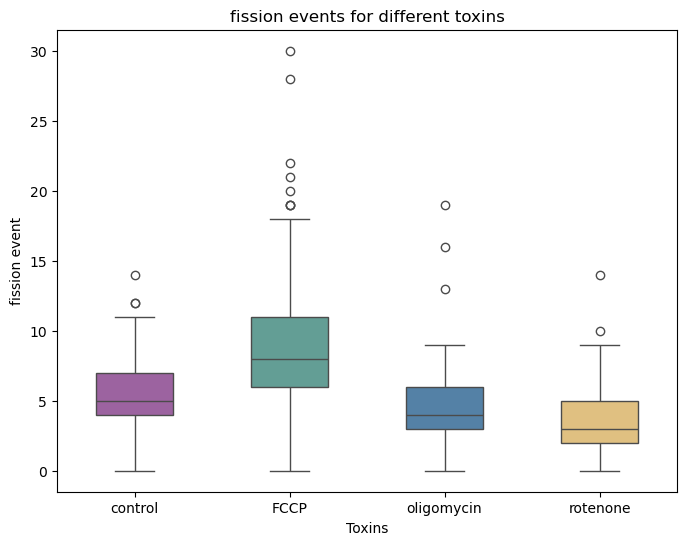

In [40]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_tox_adjusted_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission events for different toxins")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

C:\Users\iceji\AppData\Local\Temp\ipykernel_33208\1258156717.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_tox_adjusted_frame,  palette=colors, ax=ax, width=0.5)


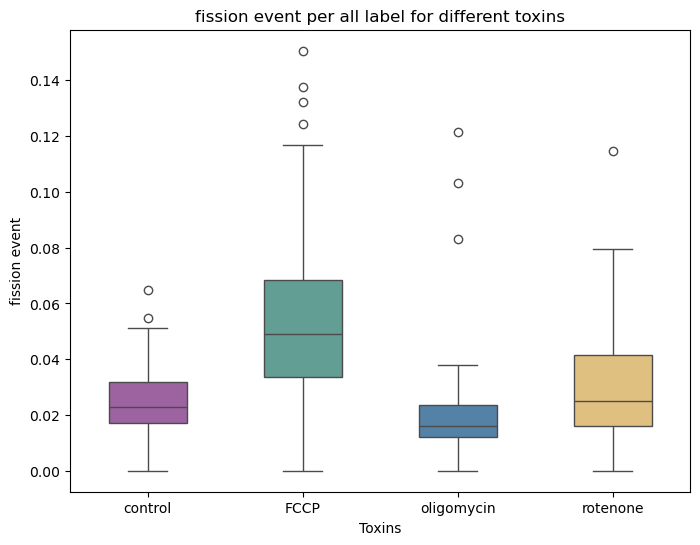

In [41]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_tox_adjusted_frame,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission event per all label for different toxins")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

C:\Users\iceji\AppData\Local\Temp\ipykernel_33208\3918067746.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_tox_adjusted_component,  palette=colors, ax=ax, width=0.5)


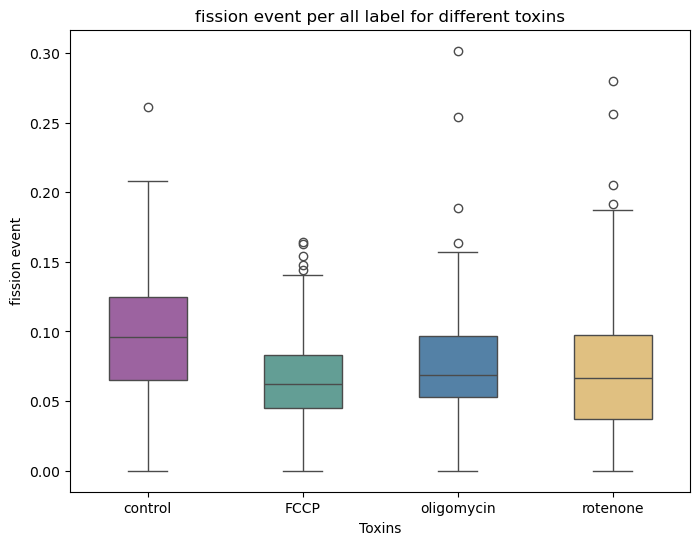

In [42]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_tox_adjusted_component,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission event per all label for different toxins")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

C:\Users\iceji\AppData\Local\Temp\ipykernel_33208\1772209151.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fission_tox_adjusted_raw_com,  palette=colors, ax=ax, width=0.5)


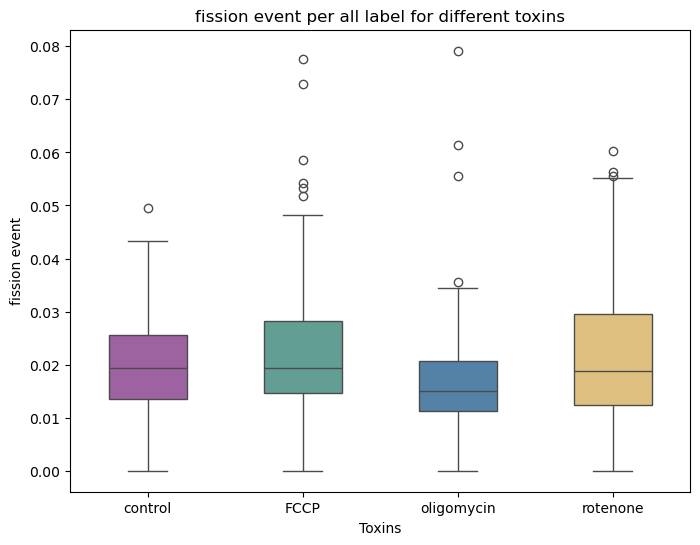

In [43]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fission_tox_adjusted_raw_com,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission event per all label for different toxins")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [32]:
normality = pg.normality(data = fusion_tox_adjusted_frame, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fusion_tox_adjusted_frame, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

print("fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_adjusted_frame, parametric=False,padjust='holm', effsize = 'r'))

                   W          pval  normal
toxin                                     
control     0.972098  6.529658e-03   False
FCCP        0.919223  5.288971e-07   False
oligomycin  0.882627  5.212892e-09   False
rotenone    0.947211  4.413768e-05   False
                W          pval  equal_var
levene  29.263895  1.490814e-17      False
fission
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  14218.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  15880.5   two-sided   
2    toxin        FCCP    rotenone   False       False  12189.5   two-sided   
3    toxin     control  oligomycin   False       False  12952.0   two-sided   
4    toxin     control    rotenone   False       False   7883.0   two-sided   
5    toxin  oligomycin    rotenone   False       False   5014.5   two-sided   

          p-unc        p-corr p-adjust         r  
0  1.714855e-13  8.574275e-13     holm  0.2

C:\Users\iceji\AppData\Local\Temp\ipykernel_33208\2261657995.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_adjusted_frame,  palette=colors, ax=ax, width=0.5)


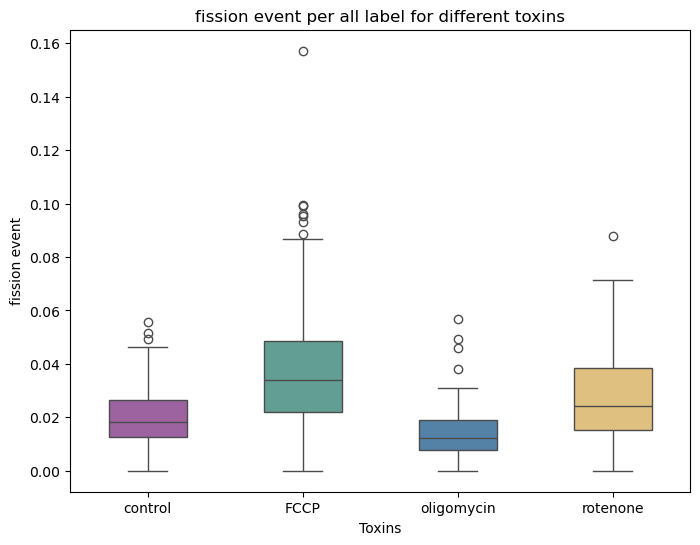

In [33]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_adjusted_frame,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission event per all label for different toxins")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [34]:
print("adjusted fusion") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_adjusted_pd, parametric=False, padjust='holm',effsize = 'r'))

adjusted fusion
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  11703.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  13579.5   two-sided   
2    toxin        FCCP    rotenone   False       False  13968.0   two-sided   
3    toxin     control  oligomycin   False       False  11853.5   two-sided   
4    toxin     control    rotenone   False       False  12310.5   two-sided   
5    toxin  oligomycin    rotenone   False       False  10052.5   two-sided   

          p-unc        p-corr p-adjust         r  
0  3.799473e-04  7.598946e-04     holm  0.292101  
1  1.232068e-10  6.160342e-10     holm  0.191349  
2  2.088923e-12  1.253354e-11     holm  0.048802  
3  1.457693e-04  4.373078e-04     holm  0.145674  
4  6.887215e-06  2.754886e-05     holm  0.038123  
5  3.033447e-01  3.033447e-01     holm  0.150918  


C:\Users\iceji\AppData\Local\Temp\ipykernel_33208\2749559227.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_adjusted_all_pd,  palette=colors, ax=ax, width=0.5)


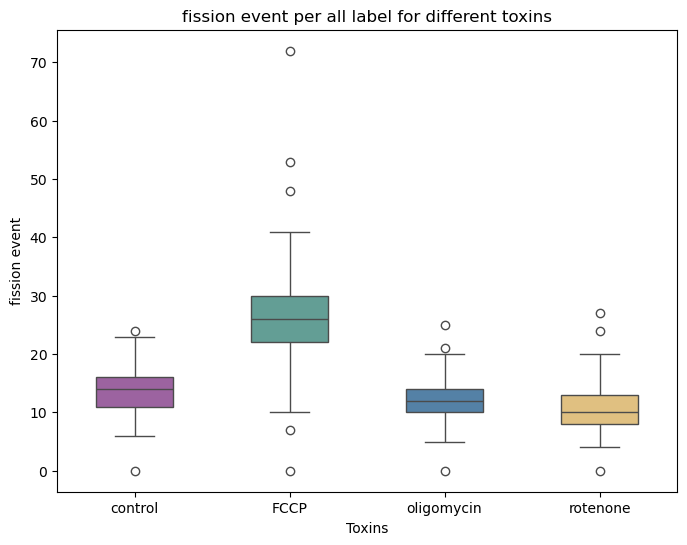

In [35]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='toxin', y='event', data=fusion_tox_adjusted_all_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission event per all label for different toxins")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

C:\Users\iceji\AppData\Local\Temp\ipykernel_33208\4239190865.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(fusion_tox_adjusted, patch_artist = True,labels=[ 'control', 'FCCP', 'oligomycin', 'Rotenone'])


ValueError: Dimensions of labels and X must be compatible

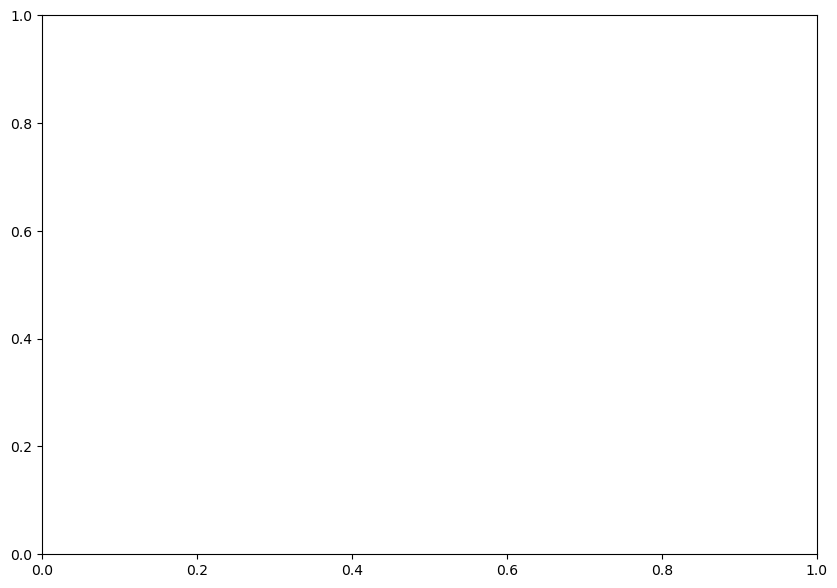

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(fusion_tox_adjusted, patch_artist = True,labels=[ 'control', 'FCCP', 'oligomycin', 'Rotenone'])

colors = ['#a559aa', '#59a89c', '#082a54', '#f0c571']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")

# changing color and linewidth of
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

for median in bp['medians']:
    median.set(color ='red',
               linewidth = 1)

# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)

#ax.set_yticklabels(['d_1', 'd_2', 
#                    'd_3', 'd_4'])
# 
plt.title("Customized box plot")

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.show()

##### Fission all & fusion all (with self fission / fusion)

In [ ]:
print("fission all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_self_pd, parametric=False,padjust='holm', effsize = 'r'))

fission all
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  17957.5   two-sided   
1    toxin        FCCP  oligomycin   False       False  18110.0   two-sided   
2    toxin        FCCP    rotenone   False       False  18340.5   two-sided   
3    toxin     control  oligomycin   False       False  10936.5   two-sided   
4    toxin     control    rotenone   False       False  13440.0   two-sided   
5    toxin  oligomycin    rotenone   False       False  12243.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  4.012893e-39  1.605157e-38     holm  0.148353  
1  1.762581e-40  8.812906e-40     holm  0.108334  
2  1.594819e-42  9.568917e-42     holm  0.154758  
3  1.735966e-02  1.735966e-02     holm  0.356664  
4  5.345371e-10  1.603611e-09     holm  0.237370  
5  1.180852e-05  2.361704e-05     holm  0.210533  


In [ ]:
print("fusion all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_self_pd, parametric=False,padjust='holm', effsize = 'r'))

fusion all
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  17876.5   two-sided   
1    toxin        FCCP  oligomycin   False       False  17987.5   two-sided   
2    toxin        FCCP    rotenone   False       False  18143.5   two-sided   
3    toxin     control  oligomycin   False       False  10293.5   two-sided   
4    toxin     control    rotenone   False       False  12843.5   two-sided   
5    toxin  oligomycin    rotenone   False       False  12387.0   two-sided   

          p-unc        p-corr p-adjust         r  
0  1.894701e-38  7.578804e-38     holm  0.124009  
1  1.987698e-39  9.938491e-39     holm  0.121058  
2  8.693538e-41  5.216123e-40     holm  0.191230  
3  1.631317e-01  1.631317e-01     holm  0.060392  
4  1.151339e-07  3.454017e-07     holm  0.228764  
5  4.039769e-06  8.079538e-06     holm  0.212683  


##### Fission fusion from mitometer

In [ ]:
print("fission mitometer") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_meter_pd, parametric=False))

fission mitometer
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  13272.5   two-sided   
1    toxin        FCCP  oligomycin   False       False  12536.0   two-sided   
2    toxin        FCCP    rotenone   False       False  10952.5   two-sided   
3    toxin     control  oligomycin   False       False   8606.0   two-sided   
4    toxin     control    rotenone   False       False   6989.0   two-sided   
5    toxin  oligomycin    rotenone   False       False   7755.0   two-sided   

          p-unc    hedges  
0  1.545791e-11  0.827871  
1  8.304499e-08  0.642336  
2  9.553068e-03  0.344610  
3  1.205285e-01 -0.207947  
4  1.190099e-05 -0.549661  
5  3.848848e-03 -0.335201  


In [ ]:
print("fusion mitometer") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_meter_pd, parametric=False))

fusion mitometer
  Contrast           A           B  Paired  Parametric   U-val alternative  \
0    toxin        FCCP     control   False       False  8957.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  9031.5   two-sided   
2    toxin        FCCP    rotenone   False       False  7665.5   two-sided   
3    toxin     control  oligomycin   False       False  9460.5   two-sided   
4    toxin     control    rotenone   False       False  8082.5   two-sided   
5    toxin  oligomycin    rotenone   False       False  8005.0   two-sided   

      p-unc    hedges  
0  0.242317 -0.167300  
1  0.327657 -0.135699  
2  0.000096 -0.515472  
3  0.846050  0.033647  
4  0.004733 -0.380774  
5  0.002577 -0.410264  


##### fission fusion from nellie

In [ ]:
print("fission nellie") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fission_tox_nellie, parametric=False,padjust='holm', effsize = 'r'))

fission nellie
  Contrast           A           B  Paired  Parametric   U-val alternative  \
0    toxin        FCCP     control   False       False  9737.5   two-sided   
1    toxin        FCCP  oligomycin   False       False  9591.0   two-sided   
2    toxin        FCCP    rotenone   False       False  9534.0   two-sided   
3    toxin     control  oligomycin   False       False  9295.0   two-sided   
4    toxin     control    rotenone   False       False  9193.0   two-sided   
5    toxin  oligomycin    rotenone   False       False  9257.0   two-sided   

      p-unc  p-corr p-adjust         r  
0  0.562350     1.0     holm -0.023779  
1  0.733129     1.0     holm -0.155143  
2  0.808087     1.0     holm -0.015978  
3  0.883703     1.0     holm -0.029409  
4  0.756942     1.0     holm  0.022033  
5  0.835985     1.0     holm  0.181949  


In [ ]:
print("fusion nellie") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = fusion_tox_nellie, parametric=False,padjust='holm', effsize = 'r'))

fusion nellie
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False   9686.5   two-sided   
1    toxin        FCCP  oligomycin   False       False   9375.0   two-sided   
2    toxin        FCCP    rotenone   False       False   9993.5   two-sided   
3    toxin     control  oligomycin   False       False   9046.0   two-sided   
4    toxin     control    rotenone   False       False   9738.0   two-sided   
5    toxin  oligomycin    rotenone   False       False  10061.5   two-sided   

      p-unc  p-corr p-adjust         r  
0  0.620818     1.0     holm -0.060014  
1  0.988238     1.0     holm -0.077647  
2  0.312035     1.0     holm  0.025597  
3  0.580427     1.0     holm  0.146061  
4  0.558297     1.0     holm  0.097277  
5  0.262824     1.0     holm  0.173865  


##### fission / fusion ratio

In [ ]:
print("fission fusion ratio") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_pd, parametric=False,padjust='holm', effsize = 'r'))

fission fusion ratio
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False   9540.5   two-sided   
1    toxin        FCCP  oligomycin   False       False   9351.5   two-sided   
2    toxin        FCCP    rotenone   False       False  10036.0   two-sided   
3    toxin     control  oligomycin   False       False   9235.5   two-sided   
4    toxin     control    rotenone   False       False   9930.0   two-sided   
5    toxin  oligomycin    rotenone   False       False  10062.5   two-sided   

      p-unc  p-corr p-adjust         r  
0  0.812515     1.0     holm  0.144816  
1  0.960449     1.0     holm  0.141226  
2  0.320659     1.0     holm -0.029604  
3  0.820642     1.0     holm  0.220179  
4  0.405573     1.0     holm -0.068325  
5  0.300845     1.0     holm  0.005985  


In [ ]:
print("fission fusion ratio adjusted") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_adjusted_pd, parametric=False,padjust='holm', effsize = 'r'))

fission fusion ratio adjusted
  Contrast           A           B  Paired  Parametric    U-val alternative  \
0    toxin        FCCP     control   False       False  10187.0   two-sided   
1    toxin        FCCP  oligomycin   False       False   9848.0   two-sided   
2    toxin        FCCP    rotenone   False       False  10568.5   two-sided   
3    toxin     control  oligomycin   False       False   9079.5   two-sided   
4    toxin     control    rotenone   False       False   9789.0   two-sided   
5    toxin  oligomycin    rotenone   False       False  10083.0   two-sided   

      p-unc    p-corr p-adjust         r  
0  0.221186  1.000000     holm  0.162965  
1  0.479950  1.000000     holm  0.077126  
2  0.070996  0.425975     holm -0.050598  
3  0.642121  1.000000     holm  0.094079  
4  0.537543  1.000000     holm -0.052607  
5  0.286639  1.000000     holm  0.122603  


In [ ]:
print("fission fusion ratio all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_all_pd, parametric=False))

fission fusion ratio all
  Contrast           A           B  Paired  Parametric   U-val alternative  \
0    toxin        FCCP     control   False       False  9356.0   two-sided   
1    toxin        FCCP  oligomycin   False       False  9721.0   two-sided   
2    toxin        FCCP    rotenone   False       False  9803.0   two-sided   
3    toxin     control  oligomycin   False       False  9694.0   two-sided   
4    toxin     control    rotenone   False       False  9771.5   two-sided   
5    toxin  oligomycin    rotenone   False       False  9402.5   two-sided   

      p-unc    hedges  
0  0.965943  0.094950  
1  0.608361  0.136510  
2  0.523799  0.064856  
3  0.637469  0.054495  
4  0.555551 -0.024607  
5  0.978703 -0.069950  


### Statistical testing of MDIVI with my algorithm

#### 1. Check assumption

In [ ]:
# fission mdivi
normality = pg.normality(data = fission_mdivi_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fission_mdivi_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                W          pval  normal
toxin                                  
control  0.894909  1.831708e-08   False
mdivi    0.872055  1.335167e-09   False
               W      pval  equal_var
levene  4.491263  0.034961      False


In [ ]:
normality = pg.normality(data = fusion_mdivi_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fusion_mdivi_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                W          pval  normal
toxin                                  
control  0.932055  3.068881e-06   False
mdivi    0.867810  8.487915e-10   False
               W      pval  equal_var
levene  2.288583  0.131473       True


In [ ]:
normality = pg.normality(data = fission_mdivi_10min_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fission_mdivi_10min_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                      W      pval  normal
toxin                                    
control_10min  0.971320  0.161929    True
mdivi_10min    0.948128  0.011754   False
               W     pval  equal_var
levene  0.974486  0.32555       True


In [ ]:
normality = pg.normality(data = fusion_mdivi_10min_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fusion_mdivi_10min_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                      W      pval  normal
toxin                                    
control_10min  0.974518  0.232228    True
mdivi_10min    0.925335  0.001141   False
               W      pval  equal_var
levene  2.091866  0.150692       True


In [ ]:
normality = pg.normality(data = fusion_mdivi_meter_pd, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = fusion_mdivi_meter_pd, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)

                W          pval  normal
toxin                                  
control  0.559831  1.159752e-18   False
mdivi    0.404555  2.195639e-21   False
               W      pval  equal_var
levene  6.242931  0.013051      False


#### 2. Statistical testing with Mann-Whitney

In [ ]:
x = int((fusion_mdivi.shape[0])/2)
# control = x, mdivi = y
print("10s interval ")
print(pg.mwu(fusion_mdivi[0:x] , fusion_mdivi[x:-1], alternative='two-sided'))
print(pg.mwu(fission_mdivi[0:x] , fission_mdivi[x:-1], alternative='two-sided'))

print(pg.mwu(fusion_mdivi_adjusted[0:x] , fusion_mdivi_adjusted[x:-1], alternative='two-sided'))
print(pg.mwu(fission_mdivi_adjusted[0:x] , fission_mdivi_adjusted[x:-1], alternative='two-sided'))

print(" ")
print(" 1 min interval")
x = int((fusion_mdivi_10min.shape[0])/2)
print(pg.mwu(fusion_mdivi_10min[0:x] , fusion_mdivi_10min[x:-1], alternative='two-sided'))
print(pg.mwu(fission_mdivi_10min[0:x] , fission_mdivi_10min[x:-1], alternative='two-sided'))

print(pg.mwu(fusion_mdivi_10min_adjusted[0:x] , fusion_mdivi_10min_adjusted[x:-1], alternative='two-sided'))
print(pg.mwu(fission_mdivi_10min_adjusted[0:x] , fission_mdivi_10min_adjusted[x:-1], alternative='two-sided'))

10s interval 
       U-val alternative     p-val     RBC     CLES
MWU  11209.0   two-sided  0.013898  0.1687  0.58435
       U-val alternative     p-val       RBC      CLES
MWU  10806.0   two-sided  0.064841  0.126681  0.563341
       U-val alternative     p-val       RBC      CLES
MWU  10922.5   two-sided  0.042347  0.138828  0.569414
       U-val alternative     p-val       RBC      CLES
MWU  10635.0   two-sided  0.111955  0.108852  0.554426
 
 1 min interval
      U-val alternative     p-val       RBC      CLES
MWU  1815.5   two-sided  0.941486 -0.007923  0.496038
      U-val alternative     p-val       RBC      CLES
MWU  2184.0   two-sided  0.064136  0.193443  0.596721
      U-val alternative     p-val      RBC      CLES
MWU  1237.5   two-sided  0.001836 -0.32377  0.338115
      U-val alternative     p-val       RBC      CLES
MWU  1919.5   two-sided  0.639562  0.048907  0.524454


In [ ]:
print("10s interval ")
print(pg.mwu(fusion_mdivi_all[0:x] , fusion_mdivi_all[x:-1], alternative='two-sided'))
print(pg.mwu(fission_mdivi_all[0:x] , fission_mdivi_all[x:-1], alternative='two-sided'))


print(" ")
print(" 1 min interval")
print(pg.mwu(fusion_mdivi_all_10min[0:x] , fusion_mdivi_all_10min[x:-1], alternative='two-sided'))
print(pg.mwu(fission_mdivi_all_10min[0:x] , fission_mdivi_all_10min[x:-1], alternative='two-sided'))

10s interval 
      U-val alternative     p-val       RBC      CLES
MWU  7134.0   two-sided  0.321286  0.082878  0.541439
      U-val alternative     p-val       RBC      CLES
MWU  6316.5   two-sided  0.622321 -0.041211  0.479394
 
 1 min interval
     U-val alternative     p-val       RBC      CLES
MWU  977.5   two-sided  0.000009 -0.465847  0.267077
     U-val alternative     p-val       RBC      CLES
MWU  950.0   two-sided  0.000005 -0.480874  0.259563


In [ ]:
x = int((fusion_mdivi.shape[0])/2)
# control = x, mdivi = y
print(pg.mwu(fusion_mdivi_meter[0:x] , fusion_mdivi_meter[x:-1], alternative='two-sided'))
print(pg.mwu(fission_mdivi_meter[0:x] , fission_mdivi_meter[x:-1], alternative='two-sided'))

print(pg.mwu(fusion_mdivi_all[0:x] , fusion_mdivi_all[x:-1], alternative='two-sided'))
print(pg.mwu(fission_mdivi_all[0:x] , fission_mdivi_all[x:-1], alternative='two-sided'))


       U-val alternative     p-val       RBC     CLES
MWU  10698.0   two-sided  0.014368  0.115421  0.55771
       U-val alternative     p-val       RBC      CLES
MWU  10522.5   two-sided  0.063727  0.097122  0.548561


#### Fission fusion ratio


In [ ]:
print("fission fusion ratio") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_mdivi, parametric=False))

print(" ")
print("fission fusion ratio 10 min") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_mdivi_10min, parametric=False))

fission fusion ratio
  Contrast        A      B  Paired  Parametric   U-val alternative     p-unc  \
0    toxin  control  mdivi   False       False  9753.0   two-sided  0.890563   

     hedges  
0 -0.227179  
 
fission fusion ratio 10 min
  Contrast              A            B  Paired  Parametric   U-val  \
0    toxin  control_10min  mdivi_10min   False       False  2073.0   

  alternative     p-unc    hedges  
0   two-sided  0.277183 -0.072235  


In [ ]:
print("fission fusion ratio adjusted") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_mdivi_adjusted, parametric=False))

print(" ")
print("fission fusion ratio 10 min adjusted") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_mdivi_adjusted_10min, parametric=False))

fission fusion ratio adjusted
  Contrast        A      B  Paired  Parametric    U-val alternative     p-unc  \
0    toxin  control  mdivi   False       False  10080.0   two-sided  0.530682   

     hedges  
0 -0.112976  
 
fission fusion ratio 10 min adjusted
  Contrast              A            B  Paired  Parametric   U-val  \
0    toxin  control_10min  mdivi_10min   False       False  2285.0   

  alternative     p-unc   hedges  
0   two-sided  0.029476  0.02839  


In [ ]:
print("fission fusion ratio all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_all_mdivi, parametric=False))

print(" ")
print("fission fusion ratio 10 min all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'toxin', data = ff_ratio_all_mdivi_10min, parametric=False))

fission fusion ratio all
  Contrast        A      B  Paired  Parametric   U-val alternative     p-unc  \
0    toxin  control  mdivi   False       False  9365.0   two-sided  0.659733   

     hedges  
0 -0.012396  
 
fission fusion ratio 10 min all
  Contrast              A            B  Paired  Parametric   U-val  \
0    toxin  control_10min  mdivi_10min   False       False  1927.5   

  alternative     p-unc    hedges  
0   two-sided  0.733345 -0.015599  


## Try two way anava analyze significance difference between two algorithm

In [ ]:
#np.mean(ff_ratio_mito_mdivi[0:x])
#np.mean(ff_ratio_mito_mdivi[x:-1])

df_ff_all = pd.concat((df_ff_ratio ,df_ff_ratio_mito))


normality = pg.normality(data = df_ff_all, dv = 'event', group = 'toxin')
homogeneity = pg.homoscedasticity(data = df_ff_all, dv = 'event', group = 'toxin')
print(normality)
print(homogeneity)


                   W          pval  normal
toxin                                     
control     0.176764  6.816448e-33   False
FCCP        0.578623  2.772587e-25   False
oligomycin  0.354072  5.145356e-30   False
rotenone    0.436756  1.885349e-28   False
              W      pval  equal_var
levene  5.00955  0.001875      False


In [ ]:
df_ff_all["assessment method"] = assess_method_tox
df_ff_all

,toxin,event,assessment method
0,control,1.000000,algorithm
1,control,0.200000,algorithm
2,control,0.900000,algorithm
3,control,3.500000,algorithm
4,control,0.800000,algorithm
...,...,...,...
543,rotenone,0.005000,mitometer
544,rotenone,0.333333,mitometer
545,rotenone,0.003333,mitometer
546,rotenone,0.005000,mitometer


In [ ]:
pg.anova(data= df_ff_all, dv = "event", between= ['toxin' , 'assessment method'])

,Source,SS,DF,MS,F,p-unc,np2
0,toxin,1.118693e+05,3,37289.774238,5.411805,1.070070e-03,0.014703
1,assessment method,4.165545e+05,1,416554.458726,60.453875,1.739071e-14,0.052639
2,toxin * assessment method,2.446709e+05,3,81556.954993,11.836229,1.243662e-07,0.031605
3,Residual,7.496811e+06,1088,6890.450889,NaN,NaN,NaN


In [ ]:
pg.pairwise_tukey(data= df_ff_all, dv = "event", between= 'assessment method')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,algorithm,mitometer,10.289456,49.280119,-38.990662,5.11851,-7.617581,0.0,-0.459879


In [ ]:
pg.pairwise_tukey(data= df_ff_all, dv = "event", between= 'toxin')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,FCCP,control,45.061731,21.788031,23.273700,7.384502,3.151695,0.009035,0.236466
1,FCCP,oligomycin,45.061731,19.646674,25.415057,7.384502,3.441675,0.003357,0.343601
2,FCCP,rotenone,45.061731,32.642714,12.419016,7.384502,1.681768,0.333804,0.146130
3,control,oligomycin,21.788031,19.646674,2.141357,7.384502,0.289980,0.991508,0.024309
4,control,rotenone,21.788031,32.642714,-10.854684,7.384502,-1.469928,0.456126,-0.111299
5,oligomycin,rotenone,19.646674,32.642714,-12.996040,7.384502,-1.759908,0.293417,-0.178590
